In [1]:
%load_ext autoreload
%autoreload 2
from dotenv import load_dotenv
load_dotenv();

In [2]:
import src.features.build_features as FeaturesManager
import src.visualization.visualize as VizManager

import numpy as np
import xgboost as xgb

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report

In [3]:
# Loading data
seasons_year = [2015, 2016, 2017, 2018]
season_type = "Regular"
features_data_df = FeaturesManager.build_features(seasons_year, season_type)
features_data_df.head()

,Game ID,Event Index,Period,Team,Type,Shot Type,Shooter,Shooter ID,Shooter Side,Shooter Ice Position,...,Game seconds,Last event angle,Rebound,Change in Shot Angle,Speed From Previous Event,Shooter Goal Ratio Last Season,Goalie Goal Ratio Last Season,Num players With,Num players Against,Elapsed time since Power Play
0,2015020001,7,1,Toronto Maple Leafs (TOR),Shot,Wrist Shot,Brad Boyes,8468504,R,R,...,51,10.525108,0.0,0.000000,13.415281,0.092715,0.066564,5.0,5.0,0.0
1,2015020001,9,1,Toronto Maple Leafs (TOR),Shot,Snap Shot,Nazem Kadri,8475172,L,C,...,65,28.300756,0.0,0.000000,6.730362,0.102273,0.066564,5.0,5.0,0.0
2,2015020001,10,1,Toronto Maple Leafs (TOR),Shot,Snap Shot,Nazem Kadri,8475172,L,C,...,66,0.000000,1.0,4.085617,2.748737,0.102273,0.066564,5.0,5.0,0.0
3,2015020001,13,1,Toronto Maple Leafs (TOR),Shot,Wrist Shot,Daniel Winnik,8471476,L,L,...,113,-93.270488,0.0,0.000000,4.302988,0.092784,0.066564,5.0,5.0,0.0
4,2015020001,21,1,Toronto Maple Leafs (TOR),Shot,Tip-In,Joffrey Lupul,8470207,R,L,...,157,47.726311,0.0,0.000000,4.085855,0.103093,0.066564,5.0,5.0,0.0


In [4]:
# Q5.1 - Baseline XGBoost model
xgb_base_model = xgb.XGBClassifier()
X = features_data_df[["Shot distance", "Shot angle"]]
y = features_data_df["Is Goal"] == True
X_train, X_test, y_train, y_test = train_test_split(X, y)
pipe = make_pipeline(StandardScaler(), xgb_base_model)

In [5]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=0, ...))])

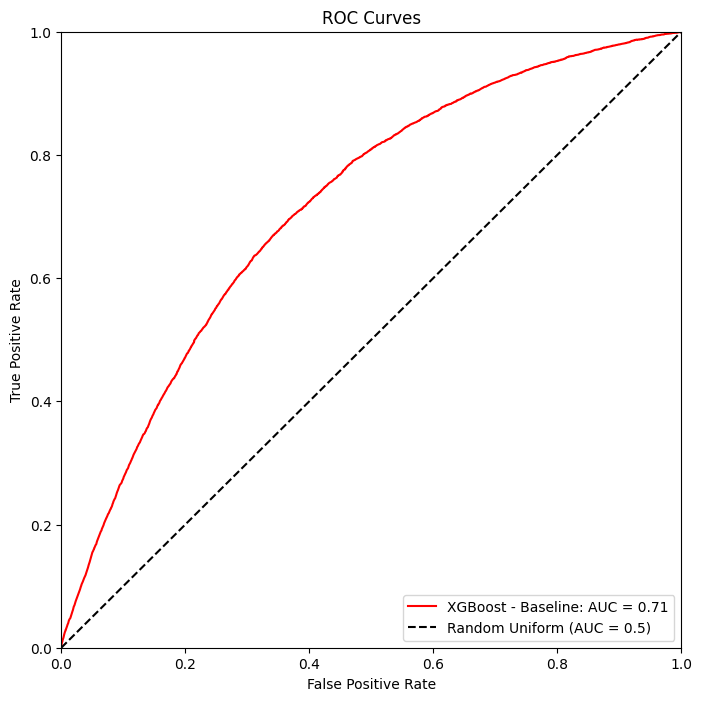

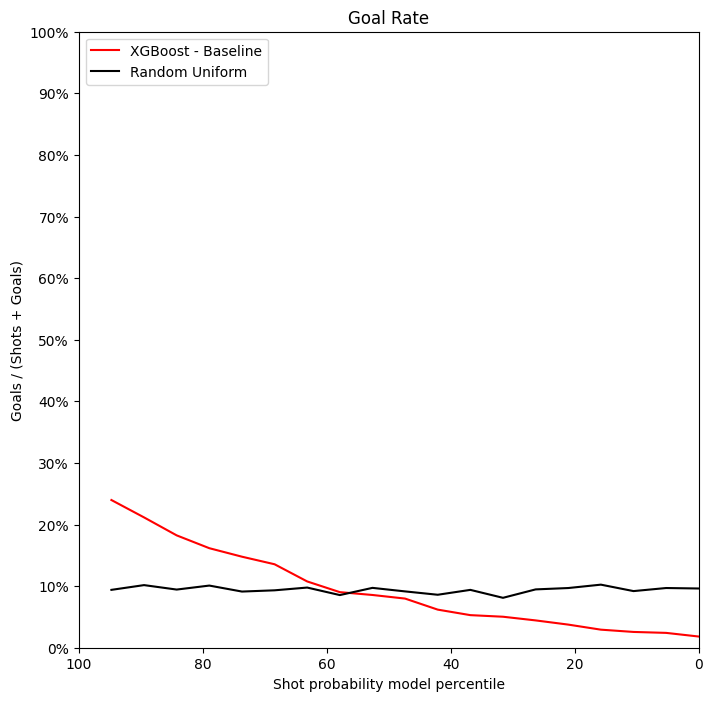

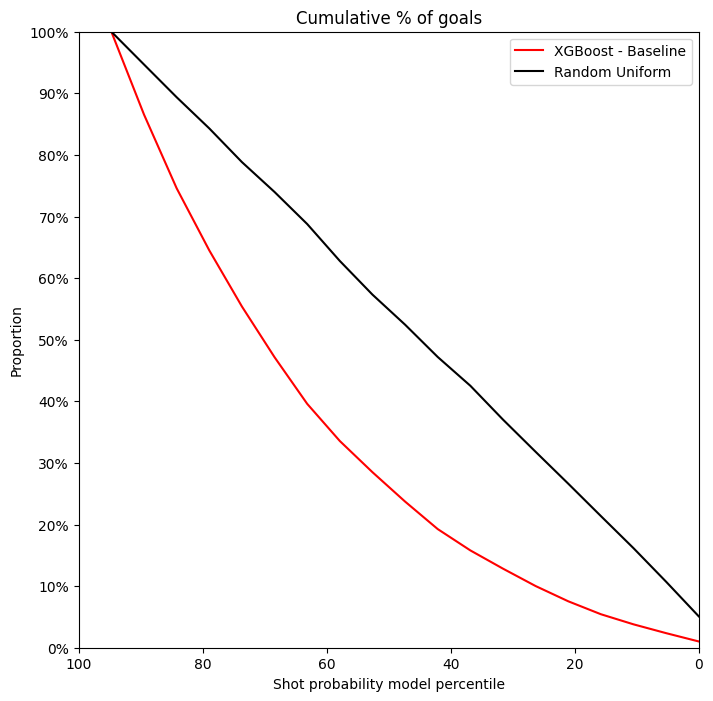

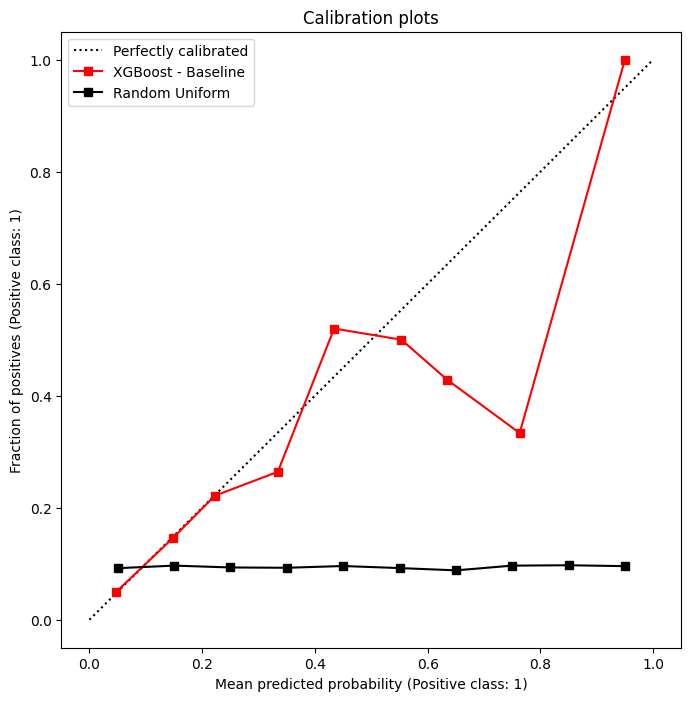

In [6]:
preds = pipe.predict_proba(X_test)
VizManager.plot_all_figures([(pipe, 'XGBoost - Baseline', X_test, y_test)])

In [7]:
print(classification_report(y_test, preds[:,1] > preds[:,0]))

              precision    recall  f1-score   support

       False       0.91      1.00      0.95     69274
        True       0.48      0.00      0.01      7191

    accuracy                           0.91     76465
   macro avg       0.69      0.50      0.48     76465
weighted avg       0.87      0.91      0.86     76465



In [14]:
# Q5.2 - Hyperparameter tuning

# Load processed data
X_train, X_test, y_train, y_test = FeaturesManager.GetTrainValid()

/mnt/c/Users/mmrz3/Desktop/IFT6758/IFT6758-A2022-G08-master/src/features/build_features.py:409: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_features = df_features.fillna(df_features.median())


In [15]:
# Only use the features that were actually mentioned in Q4
X_train = X_train[['Period seconds', 'Period', 'st_X', 'st_Y', 'Shot distance', 'Shot angle', 'Shot_Type_Backhand', 'Shot_Type_Deflected', 'Shot_Type_Slap Shot', 'Shot_Type_Snap Shot', 'Shot_Type_Tip-In', 'Shot_Type_Wrap-around', 'Shot_Type_Wrist Shot', 'Last event st_X', 'Last event st_Y', 'Last event elapsed time', 'Last event distance', 'Rebound', 'Change in Shot Angle', 'Speed From Previous Event']]
X_test = X_test[['Period seconds', 'Period', 'st_X', 'st_Y', 'Shot distance', 'Shot angle', 'Shot_Type_Backhand', 'Shot_Type_Deflected', 'Shot_Type_Slap Shot', 'Shot_Type_Snap Shot', 'Shot_Type_Tip-In', 'Shot_Type_Wrap-around', 'Shot_Type_Wrist Shot', 'Last event st_X', 'Last event st_Y', 'Last event elapsed time', 'Last event distance', 'Rebound', 'Change in Shot Angle', 'Speed From Previous Event']]

In [17]:
from src.models.HP_XGBoost import XGBoost_GridSearch

grid_search, X_test = XGBoost_GridSearch(X_train, X_test, y_train, y_test)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: xgboost, sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758-a22-g08/hyperparameters-xgboost/bbb0f7a207f34949af41bd65782ce9f0
COMET INFO:   Metrics:
COMET INFO:     mean_fit_time        : 30.420926809310913
COMET INFO:     mean_score_time      : 0.13146638870239258
COMET INFO:     mean_test_AUC        : 0.758772992268127
COMET INFO:     mean_test_Accuracy   : 0.9069672397039351
COMET INFO:     param_gamma          : 6
COMET INFO:     param_learning_rate  : 0.3
COMET INFO:     param_max_depth      : 8
COMET INFO:     rank_test_AUC        : 23
COMET INFO:     ran

In [48]:
grid_search.best_params_

{'gamma': 6, 'learning_rate': 0.1, 'max_depth': 8}

In [ ]:
VizManager.plot_all_figures([(grid_search, 'XGBoost - GridSearchCV', X_test, y_test)])

In [50]:
preds = pipe.predict_proba(X_test)
print(classification_report(y_test, preds[:,1] > preds[:,0]))

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     55434
         1.0       0.65      0.03      0.06      5738

    accuracy                           0.91     61172
   macro avg       0.78      0.52      0.51     61172
weighted avg       0.88      0.91      0.87     61172

